# TensorRider Algorithm

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorlayer as tl
import time
import winsound

from tensorlayer.layers import *
LayersConfig.tf_dtype = tf.float16  # tf.float32  tf.float16

In [2]:
sess = tf.InteractiveSession()

In [3]:
def rgb2mono(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    # mono = 0.2989 * r + 0.5870 * g + 0.1140 * b
    mono = 0.5 * r + 0.25 * g + 0.25 * b
    return mono

In [4]:
def prepareDataArrays(iterator):
    X = np.zeros(4800)
    y = np.zeros(1)
    recordCounter = 0;

    for string_record in iterator:
        recordCounter += 1

        example = tf.train.Example()
        example.ParseFromString(string_record)
        imageString = (example.features.feature['image'].bytes_list.value[0])
        label = (example.features.feature['label'].int64_list.value[0])

        image = np.fromstring(imageString, dtype=np.uint8)
        image = image.reshape((60, 80, 3))
        image = rgb2mono(image)
        image = image.reshape((4800))
        
        X = np.append(X,image)
        y = np.append(y,label)
        if recordCounter % 100 == 0:
            print(recordCounter,end = '->')
            
    X = X.reshape((recordCounter + 1, 60, 80, 1))
    y = y.reshape((recordCounter + 1,))
    y = np.round(y / 12)
    y = y + 3
    return X, y

In [5]:
trainIterator = tf.python_io.tf_record_iterator(path="train.tfrecords")
valIterator = tf.python_io.tf_record_iterator(path="val.tfrecords")
testIterator = tf.python_io.tf_record_iterator(path="test.tfrecords")

# TFRecords -> Arrays

In [9]:
print("\nTrain...")
X_train, y_train = prepareDataArrays(trainIterator)
print("\nVal...")
X_val, y_val = prepareDataArrays(valIterator)
print("\nTest...")
X_test, y_test = prepareDataArrays(testIterator)


Train...
100->

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


200->300->400->500->600->700->800->900->1000->1100->1200->1300->1400->1500->1600->1700->1800->1900->2000->2100->2200->2300->2400->2500->2600->2700->2800->2900->3000->3100->3200->3300->3400->3500->3600->3700->3800->3900->4000->4100->4200->4300->4400->4500->4600->4700->4800->4900->5000->5100->5200->5300->5400->5500->5600->5700->5800->5900->6000->6100->6200->6300->6400->6500->6600->6700->6800->6900->7000->7100->7200->7300->7400->7500->7600->7700->7800->7900->8000->8100->8200->8300->8400->8500->8600->8700->8800->8900->9000->9100->9200->9300->9400->9500->9600->9700->9800->9900->10000->10100->10200->10300->10400->10500->10600->10700->10800->10900->11000->11100->11200->11300->11400->11500->11600->11700->11800->11900->12000->12100->12200->12300->12400->12500->12600->12700->12800->12900->13000->13100->13200->13300->13400->13500->
Val...
100->200->300->400->500->600->700->800->900->1000->1100->1200->1300->1400->1500->1600->1700->1800->1900->2000->2100->2200->2300->2400->2500->2600->2700->
Test..

# Arrays -> NPZ File

In [12]:
np.savez("arrays2d.npz", xtr = X_train, ytr = y_train, xval = X_val, yval = y_val, xt = X_test, yt = y_test)

# NPZ File -> Arrays

In [6]:
npRecall = np.load("arrays2d.npz")
X_train = npRecall["xtr"]
y_train = npRecall["ytr"]
X_val = npRecall["xval"]
y_val = npRecall["yval"]
X_test = npRecall["xt"]
y_test = npRecall["yt"]

# Visualization

(array([4.930e+02, 0.000e+00, 4.565e+03, 0.000e+00, 4.786e+03, 0.000e+00,
        3.352e+03, 0.000e+00, 3.960e+02, 3.000e+00]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

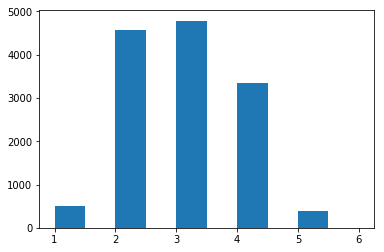

In [7]:
plt.hist(y_train)
# plt.hist(y_val)
# plt.hist(y_test)

# Define the Neural Network

In [6]:
batch_size = 128

x = tf.placeholder(LayersConfig.tf_dtype, shape=[batch_size, 60, 80, 1])
y_ = tf.placeholder(tf.int64, shape=[batch_size])

rx = tf.placeholder(LayersConfig.tf_dtype, shape=[1, 60, 80, 1])
ry_ = tf.placeholder(tf.int64, shape=[1])

In [7]:
def model(x, is_train=True, reuse=False):
    with tf.variable_scope("model", reuse=reuse):
        n = InputLayer(x, name='input')
        # cnn
        n = Conv2d(n, 32, (5, 5), (1, 1), padding='SAME', name='cnn1')
        n = BatchNormLayer(n, act=tf.nn.relu, is_train=is_train, name='bn1')
        n = MaxPool2d(n, (2, 2), (2, 2), padding='SAME', name='pool1')
        n = Conv2d(n, 64, (5, 5), (1, 1), padding='SAME', name='cnn2')
        n = BatchNormLayer(n, act=tf.nn.relu, is_train=is_train, name='bn2')
        n = MaxPool2d(n, (2, 2), (2, 2), padding='SAME', name='pool2')
        # mlp
        n = FlattenLayer(n, name='flatten')
        n = DropoutLayer(n, 0.5, True, is_train, name='drop1')
        n = DenseLayer(n, 256, act=tf.nn.relu, name='relu1')
        n = DropoutLayer(n, 0.5, True, is_train, name='drop2')
        n = DenseLayer(n, 7, act=tf.identity, name='output')
    return n

In [8]:
# define inferences
net_train = model(x, is_train=True, reuse=False)
net_test = model(x, is_train=False, reuse=True)

net_train.print_params(False)

[TL] InputLayer  model/input: (128, 60, 80, 1)
[TL] Conv2dLayer model/cnn1: shape:(5, 5, 1, 32) strides:(1, 1, 1, 1) pad:SAME act:identity
[TL] BatchNormLayer model/bn1: decay:0.900000 epsilon:0.000010 act:relu is_train:True
[TL] PoolLayer   model/pool1: ksize:[1, 2, 2, 1] strides:[1, 2, 2, 1] padding:SAME pool:max_pool
[TL] Conv2dLayer model/cnn2: shape:(5, 5, 32, 64) strides:(1, 1, 1, 1) pad:SAME act:identity
[TL] BatchNormLayer model/bn2: decay:0.900000 epsilon:0.000010 act:relu is_train:True
[TL] PoolLayer   model/pool2: ksize:[1, 2, 2, 1] strides:[1, 2, 2, 1] padding:SAME pool:max_pool
[TL] FlattenLayer model/flatten: 19200
[TL] DropoutLayer model/drop1: keep:0.500000 is_fix:True
[TL] DenseLayer  model/relu1: 256 relu
[TL] DropoutLayer model/drop2: keep:0.500000 is_fix:True
[TL] DenseLayer  model/output: 7 identity
[TL] InputLayer  model/input: (128, 60, 80, 1)
[TL] Conv2dLayer model/cnn1: shape:(5, 5, 1, 32) strides:(1, 1, 1, 1) pad:SAME act:identity
[TL] BatchNormLayer model/bn1

In [9]:
# cost for training
y = net_train.outputs
cost = tl.cost.cross_entropy(y, y_, name='xentropy')

# cost and accuracy for evalution
y2 = net_test.outputs
cost_test = tl.cost.cross_entropy(y2, y_, name='xentropy2')
correct_prediction = tf.equal(tf.argmax(y2, 1), y_)
acc = tf.reduce_mean(tf.cast(correct_prediction, LayersConfig.tf_dtype))

In [10]:
# define the optimizer
train_params = tl.layers.get_variables_with_name('model', train_only=True, printable=False)
train_op = tf.train.AdamOptimizer(
    learning_rate=0.0001,
    beta1=0.9,
    beta2=0.999,
    # epsilon=1e-08,    # for float32 as default
    epsilon=1e-4,  # for float16, see https://stackoverflow.com/questions/42064941/tensorflow-float16-support-is-broken
    use_locking=False).minimize(cost, var_list=train_params)

[TL]   [*] geting variables with model


In [11]:
# initialize all variables in the session
tl.layers.initialize_global_variables(sess)

# Start Training

In [14]:
# train the network
n_epoch = 200
print_freq = 1

winsound.PlaySound("*", winsound.SND_ALIAS)

for epoch in range(n_epoch):
    start_time = time.time()
    for X_train_a, y_train_a in tl.iterate.minibatches(X_train, y_train, batch_size, shuffle=True):
        sess.run(train_op, feed_dict={x: X_train_a, y_: y_train_a})

    if epoch + 1 == 1 or (epoch + 1) % print_freq == 0:
        print("Epoch %d of %d took %fs" % (epoch + 1, n_epoch, time.time() - start_time))
        train_loss, train_acc, n_batch = 0, 0, 0
        for X_train_a, y_train_a in tl.iterate.minibatches(X_train, y_train, batch_size, shuffle=True):
            err, ac = sess.run([cost_test, acc], feed_dict={x: X_train_a, y_: y_train_a})
            train_loss += err
            train_acc += ac
            n_batch += 1
        print("   train loss: %f" % (train_loss / n_batch))
        print("   train acc: %f" % (train_acc / n_batch))
        val_loss, val_acc, n_batch = 0, 0, 0
        for X_val_a, y_val_a in tl.iterate.minibatches(X_val, y_val, batch_size, shuffle=True):
            err, ac = sess.run([cost_test, acc], feed_dict={x: X_val_a, y_: y_val_a})
            val_loss += err
            val_acc += ac
            n_batch += 1
        print("   val loss: %f" % (val_loss / n_batch))
        print("   val acc: %f" % (val_acc / n_batch))
        
winsound.PlaySound("*", winsound.SND_ALIAS)

Epoch 1 of 200 took 15.529488s
   train loss: 0.883107
   train acc: 0.729805
   val loss: 1.049456
   val acc: 0.690848
Epoch 2 of 200 took 14.059394s
   train loss: 0.911870
   train acc: 0.634655
   val loss: 1.065871
   val acc: 0.508557
Epoch 3 of 200 took 14.196236s
   train loss: 0.872103
   train acc: 0.724425
   val loss: 0.990676
   val acc: 0.681920
Epoch 4 of 200 took 14.257980s
   train loss: 0.755694
   train acc: 0.747420
   val loss: 0.864932
   val acc: 0.728051
Epoch 5 of 200 took 14.339309s
   train loss: 0.730639
   train acc: 0.748157
   val loss: 0.820592
   val acc: 0.741443
Epoch 6 of 200 took 14.321448s
   train loss: 0.680028
   train acc: 0.750590
   val loss: 0.773786
   val acc: 0.734747
Epoch 7 of 200 took 14.232432s
   train loss: 0.664205
   train acc: 0.750295
   val loss: 0.761440
   val acc: 0.741815
Epoch 8 of 200 took 14.365364s
   train loss: 0.657890
   train acc: 0.753611
   val loss: 0.751767
   val acc: 0.736607
Epoch 9 of 200 took 14.528964s
 

   train loss: 0.540594
   train acc: 0.784051
   val loss: 0.745117
   val acc: 0.747768
Epoch 69 of 200 took 14.424144s
   train loss: 0.539228
   train acc: 0.783977
   val loss: 0.761602
   val acc: 0.755580
Epoch 70 of 200 took 14.503065s
   train loss: 0.558089
   train acc: 0.780881
   val loss: 0.757022
   val acc: 0.736607
Epoch 71 of 200 took 14.712161s
   train loss: 0.532789
   train acc: 0.788694
   val loss: 0.740234
   val acc: 0.753348
Epoch 72 of 200 took 14.492379s
   train loss: 0.553211
   train acc: 0.785598
   val loss: 0.736956
   val acc: 0.746280
Epoch 73 of 200 took 14.431555s
   train loss: 0.526678
   train acc: 0.787294
   val loss: 0.739397
   val acc: 0.751488
Epoch 74 of 200 took 14.390351s
   train loss: 0.536071
   train acc: 0.785156
   val loss: 0.736700
   val acc: 0.755208
Epoch 75 of 200 took 14.476315s
   train loss: 0.531609
   train acc: 0.785820
   val loss: 0.749628
   val acc: 0.757068
Epoch 76 of 200 took 14.480296s
   train loss: 0.535080


   train loss: 0.431542
   train acc: 0.830999
   val loss: 0.676502
   val acc: 0.733259
Epoch 136 of 200 took 14.090227s
   train loss: 0.425399
   train acc: 0.831810
   val loss: 0.643590
   val acc: 0.774554
Epoch 137 of 200 took 14.254581s
   train loss: 0.416260
   train acc: 0.832621
   val loss: 0.707357
   val acc: 0.767485
Epoch 138 of 200 took 14.228052s
   train loss: 0.424425
   train acc: 0.834242
   val loss: 0.691848
   val acc: 0.758929
Epoch 139 of 200 took 14.285753s
   train loss: 0.412307
   train acc: 0.837780
   val loss: 0.641288
   val acc: 0.765253
Epoch 140 of 200 took 14.230137s
   train loss: 0.417881
   train acc: 0.830336
   val loss: 0.703358
   val acc: 0.755580
Epoch 141 of 200 took 14.060388s
   train loss: 0.451381
   train acc: 0.829231
   val loss: 0.644624
   val acc: 0.756696
Epoch 142 of 200 took 14.042707s
   train loss: 0.402245
   train acc: 0.840949
   val loss: 0.723110
   val acc: 0.739211
Epoch 143 of 200 took 14.207147s
   train loss: 0

# Test the Neural Network

In [15]:
test_loss, test_acc, n_batch = 0, 0, 0
for X_test_a, y_test_a in tl.iterate.minibatches(X_test, y_test, batch_size, shuffle=True):
    err, ac = sess.run([cost_test, acc], feed_dict={x: X_test_a, y_: y_test_a})
    test_loss += err
    test_acc += ac
    n_batch += 1
print("   test loss: %f" % (test_loss / n_batch))
print("   test acc: %f" % (test_acc / n_batch))

   test loss: 0.662489
   test acc: 0.700810


# Save the Trained Model

In [16]:
tl.files.save_npz(net_train.all_params, name='model2d.npz')
sess.close()

[TL] [*] model2d.npz saved


# Load the Trained Model

In [12]:
tl.files.load_and_assign_npz(sess=sess, name='model2d.npz', network=net_test)

[TL] [*] Load model2d.npz SUCCESS!


# Controlling TensorRider Using the Generated Model

In [13]:
import cv2
from IPython import display
import urllib.request
import numpy as np
import socket
import threading
from time import ctime,sleep
import string

remoteImage = np.array([])
stream = urllib.request.urlopen('http://192.168.73.73:8080/?action=stream&ignored.mjpg')
bytes = bytes()

In [14]:
def Image_Refreshing_Thread():
    global remoteImage
    global stream
    global bytes
    while True:
        bytes += stream.read(1024)
        a = bytes.find(b'\xff\xd8')
        b = bytes.find(b'\xff\xd9')
        if a != -1 and b != -1:
            jpg = bytes[a:b+2]
            bytes = bytes[b+2:]
            i = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
            i = rgb2mono(i)
            remoteImage = i.reshape((1,60,80,1))

In [15]:
def Controlling_Thread():
    global remoteImage
    imgArray4d = np.zeros((128,60,80,1))
    addr=('192.168.73.73',51423)
    s=socket.socket(socket.AF_INET,socket.SOCK_DGRAM)
    while True:
        for index in range(128):
            imgArray4d[index,:,:,0] = remoteImage[0,:,:,0]
            
        direction = tl.utils.predict(sess, net_test, imgArray4d, x, y_op, batch_size=None)
        msgCtrl_Udp = str(25) + "," + str((direction[0] - 3) * 15)
#         print(msgCtrl_Udp)
        s.sendto(msgCtrl_Udp.encode('utf-8'), addr)
        sleep(0.1)

In [16]:
y_op = tf.argmax(tf.nn.softmax(y), 1)

In [17]:
RefreshImageThread = threading.Thread(target = Image_Refreshing_Thread)
RefreshImageThread.start()

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


In [18]:
ControllingThread = threading.Thread(target = Controlling_Thread)
ControllingThread.start()

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':
